### Introduction

Ontario Parks released dataset on visitation counts for all operating provincial parks [here:]( https://data.ontario.ca/en/dataset/visitation-to-provincial-parks)

In this project, I will first visualize this dataset and then try to use machine learning to find out which features(e.g. beach? trails?) make a provincial park more popular than others.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_excel('OntarioParks.xlsx')
df

,Zone,Park,Year,Day Visitation,Camper Nights,Total Visitation,July August Car Camping Occupancy
0,Northwest,aaron,2020,2672.8,19459.0,22131.8,0.46
1,Algonquin,algonquin,2020,224904.0,809473.4,1034377.4,0.93
2,Algonquin,arrowhead,2020,120360.0,139690.4,260050.4,0.95
3,Northwest,arrowlake,2020,0.0,10035.0,10035.0,0.81
4,Southwest,awenda,2020,55026.0,97179.4,152205.4,0.95
...,...,...,...,...,...,...,...
109,Southwest,wasagabeach,2020,1373948.3,0.0,1373948.3,NaN
110,Southwest,wheatley,2020,7006.0,68251.2,75257.2,0.73
111,Northwest,whitelake,2020,2257.2,26749.9,29007.1,0.58
112,Northeast,windylake,2020,15022.0,20351.4,35373.4,0.92


In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,114.0,2020.000000,0.000000,2020.0,2020.0000,2020.00,2020.00,2020.00
Day Visitation,114.0,48106.298246,144406.168849,0.0,1736.0000,12250.75,33226.45,1373948.30
Camper Nights,111.0,51042.247748,91161.473905,0.0,8970.8000,27909.10,63841.60,809473.40
Total Visitation,114.0,97805.328947,184752.100420,0.0,17731.0000,49235.40,91861.85,1373948.30
July August Car Camping Occupancy,86.0,0.767558,0.226643,0.0,0.7025,0.84,0.92,0.99


In [16]:
df['Zone'].value_counts()

Northeast    34
Southeast    27
Southwest    24
Northwest    22
Algonquin     6
All           1
Name: Zone, dtype: int64

In [17]:
df[df['Zone']=='All']

,Zone,Park,Year,Day Visitation,Camper Nights,Total Visitation,July August Car Camping Occupancy
105,All,unassigned,2020,17683.0,NaN,17683.0,NaN


### Data collection/integrity overview

A quick look at the data, we discover that 'Year' column is always 2020, so we can safely drop this column. 'Zone' features divides parks into 6 categories, however, one of the zones is 'All', and only contain one row, and it is 'unassigned' park, so we should drop this row as well.

There are two main metrics for visitation: 'Day Visitation' and 'Camper Nights', according to the data notes, 'Day Visitation' is 
>average occupants/vehicle x number of daily vehicle permits + average occupants/vehicle x number of annual vehicle permits x average number of visits + number of bus permits x average occupants 

and 'Camper Nights' is
>Camper Nights is defined as one camper staying in a provincial park for one night.  It is comprised of car camping, group camping and interior camping. 

'Total Visitation' is simply the sum of the two, and 'July August Car Camping Occupancy' describes percentage of campsites occupied out of all available campsites. We can see that Day Visitation is an estimate based on permits sold and historical average for each permit type, so this data might not be totally accurate, but camper nights and camping occupancy are based on actual total bookings and actual total camp sites, so these numbers should be highly accurate. This data directly came from Ontario Open Data, so there is no reason to doubt the data source accuracy.

In [18]:
df = df.drop('Year', axis=1) # drop 'Year' column since they are all 2020
df = df.drop(105) # drop row 105 where park is 'unassigned'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 0 to 113
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zone                               113 non-null    object 
 1   Park                               113 non-null    object 
 2   Day Visitation                     113 non-null    float64
 3   Camper Nights                      111 non-null    float64
 4   Total Visitation                   113 non-null    float64
 5   July August Car Camping Occupancy  86 non-null     float64
dtypes: float64(4), object(2)
memory usage: 6.2+ KB


### Data Visualization/ First intuition
Both day visitation and camper nights are such big numbers, let's visualize them with a scatterplot:

There are 5 or 6 clear outliers, I have added annotations to the plot.

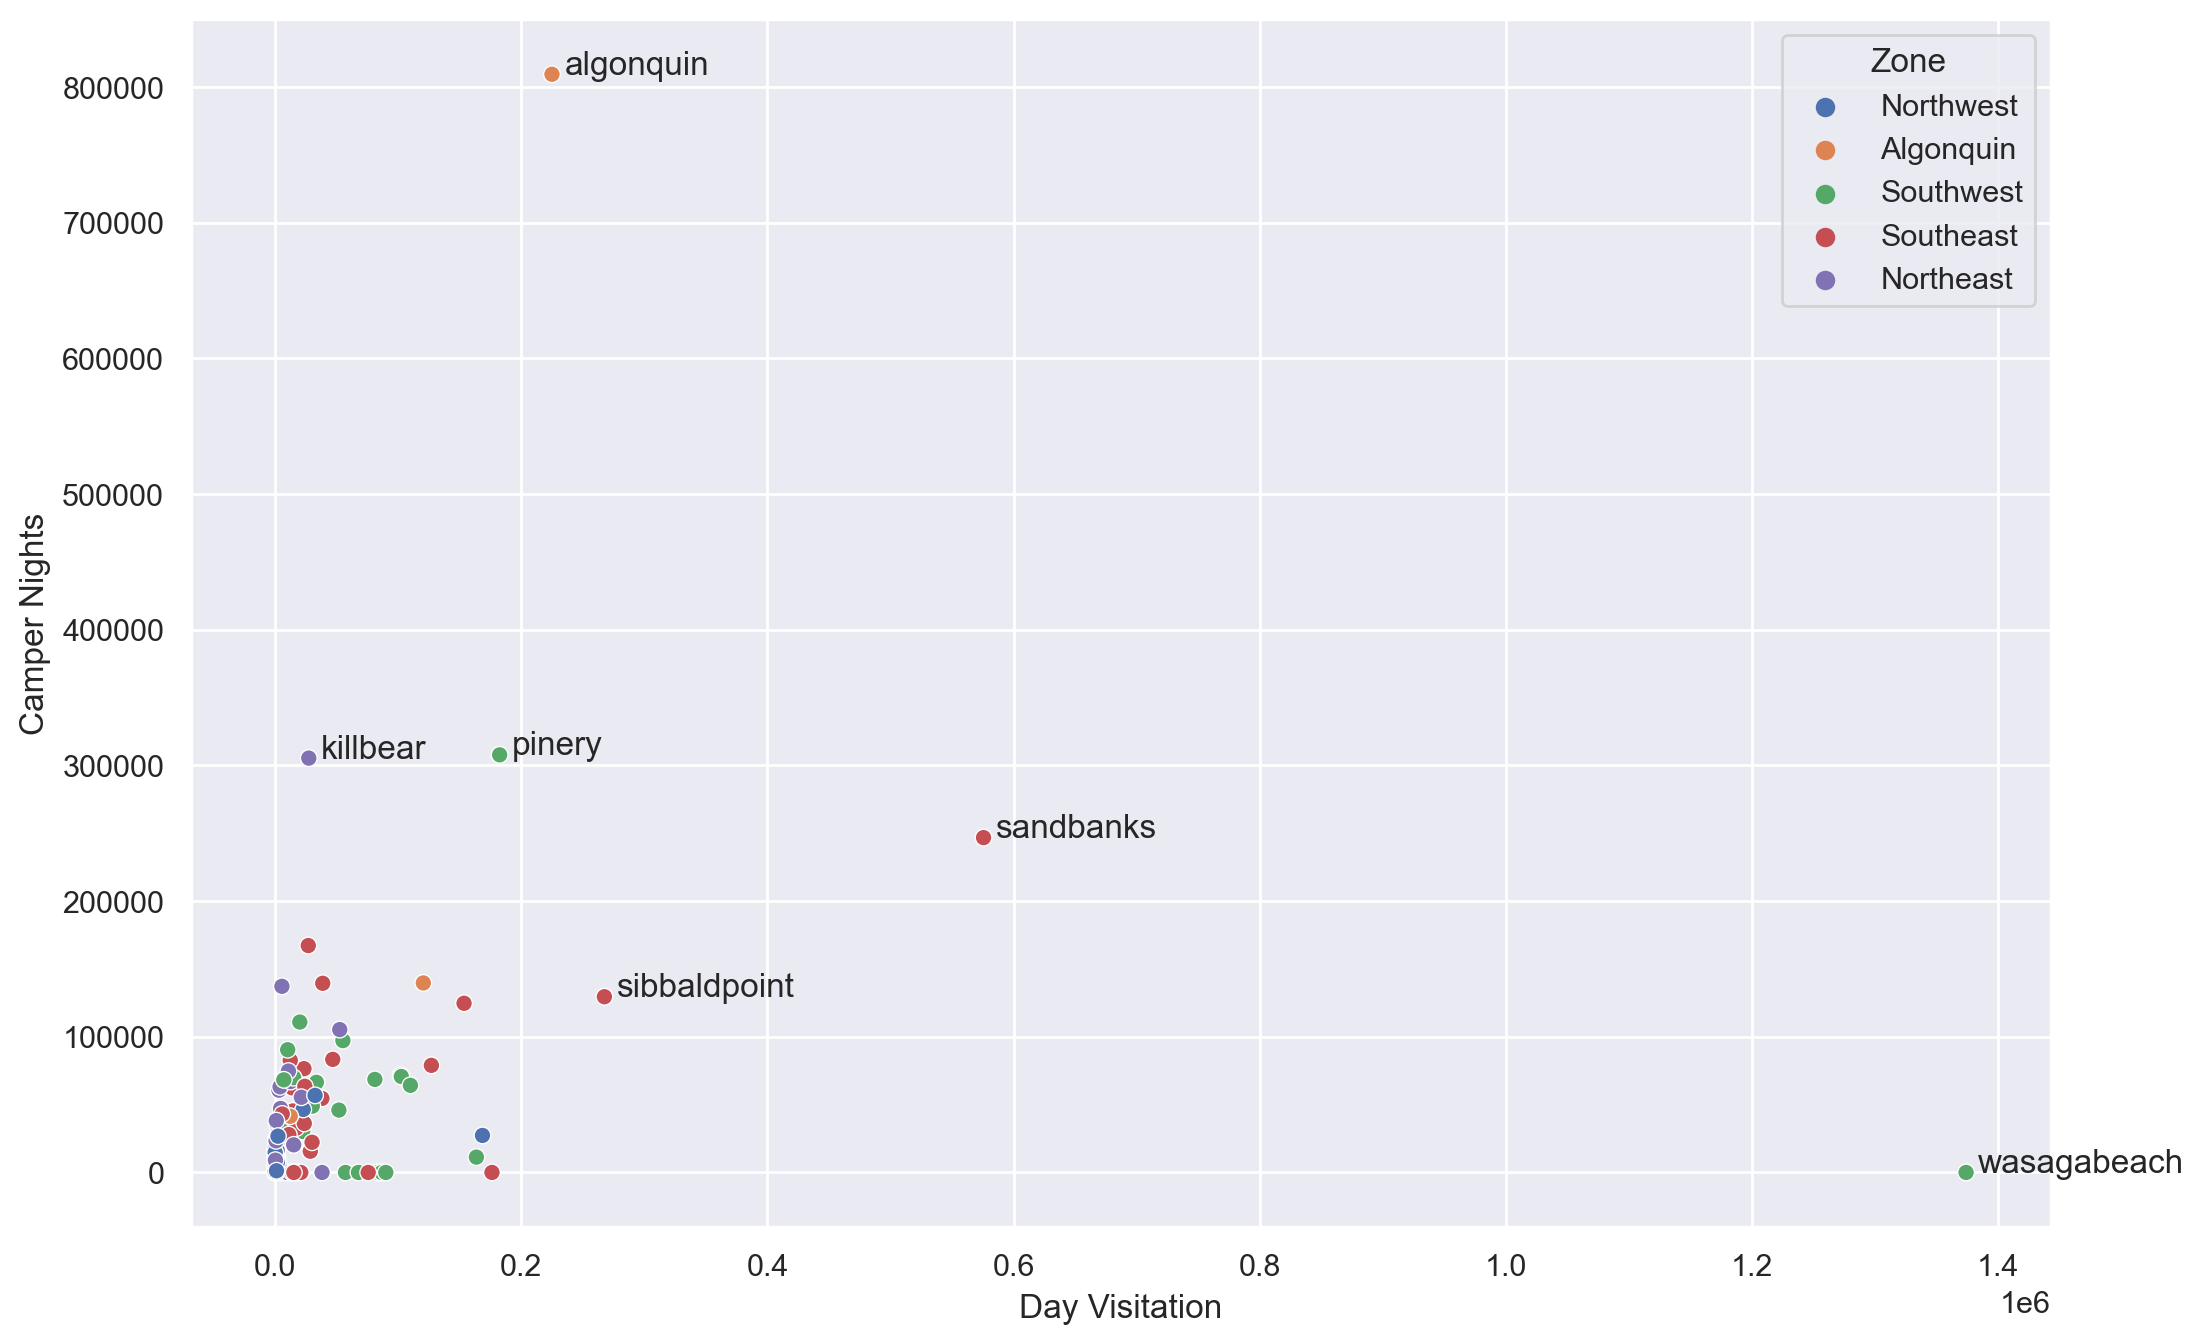

In [20]:
plt.figure(figsize=(12,8), dpi=200)
sns.set_theme()
p1 = sns.scatterplot(data=df, x='Day Visitation', y='Camper Nights', hue='Zone')
# find the top 6 parks with most total visitors and then annotate them on thep plot. 
top_parks = [x for x in df.sort_values('Total Visitation', ascending=False)['Park'].head(6)]
for park in top_parks:
    plt.text(x=df['Day Visitation'][df['Park']==park]+10000, 
             y=df['Camper Nights'][df['Park']==park], s=park)

Just from this scatterplot, we can clearly see the outliers: Wasagabeach has by far the highest number of day visitations(more than twice as much as the next highest, Sandbanks), and it doesn't even allow camping! Algonquin park has the most campers by a long shot, but relatively not as many day-use visitors. Killbear, Pinery and Sandbanks have roughly same amount of campers, but day visitors vary a lot. I would guess that those 6 most popular parks are all relatively close to the GTA, I will use Tableau to check if this is true.

### Maping the dataset with Tableau

The original dataset does not contain any geolocation data, and currently Tableau does not recognize park names as locations. Fortunately we can use Google Map's API to find coordinates for each park based on park name:

In [33]:
import requests
import json

API_Key = "REDACTED"
park_list = df['Park']
f = open("parks.txt", "w")
for park_name in park_list:
    url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input="
    +park_name+"provincial park"+"%20in%20Ontario&inputtype=textquery&fields=geometry&key="+API_key
    payload = {}
    headers = {}
    response = requests.request("GET", url, headers=headers, data=payload)
    test = json.loads(response.text)
    # unpacking the response we got from Google, and saving it in a csv file
    f.write(park_name +","+ str(test["candidates"][0]["geometry"]["location"]['lat']) + ","+
            str(test["candidates"][0]["geometry"]["location"]['lng']))
f.close()

# Now that we have the coordinates saved in the text file we created, let's merge that with existing data
parks_coor = pd.read_csv('parks_coor.txt')
df1 = pd.merge(df, parks_coor, how='left', on='Park') # SQL style LEFT JOIN to preserve all rows from df 
df1

,Zone,Park,Year,Day Visitation,Camper Nights,Total Visitation,July August Car Camping Occupancy,LAT,LNG
0,Northwest,aaron,2020,2672.8,19459.0,22131.8,0.46,49.757880,-92.653782
1,Algonquin,algonquin,2020,224904.0,809473.4,1034377.4,0.93,45.837159,-78.379124
2,Algonquin,arrowhead,2020,120360.0,139690.4,260050.4,0.95,45.391553,-79.214678
3,Northwest,arrowlake,2020,0.0,10035.0,10035.0,0.81,48.176964,-90.227271
4,Southwest,awenda,2020,55026.0,97179.4,152205.4,0.95,44.817400,-79.983409
...,...,...,...,...,...,...,...,...,...
109,Southwest,wasagabeach,2020,1373948.3,0.0,1373948.3,NaN,44.487014,-80.063705
110,Southwest,wheatley,2020,7006.0,68251.2,75257.2,0.73,42.088695,-82.445486
111,Northwest,whitelake,2020,2257.2,26749.9,29007.1,0.58,48.714100,-85.659456
112,Northeast,windylake,2020,15022.0,20351.4,35373.4,0.92,46.619148,-81.446128


Now that we have geolocation data, we can plot visitation data on map using Tableau, for easy reference.
you can view the interactive version here: https://public.tableau.com/app/profile/will.ye/viz/OntarioParksVisitors/TotalVisits

And... Yes, my intuition was correct, all of the most popular parks are close to the GTA(3 hours drive or so)
But besides proximity to GTA, what other features make some parks more popular than others? And, if Ontario were to  create a new Provincial Park, can we predict how many visitors it will attract?


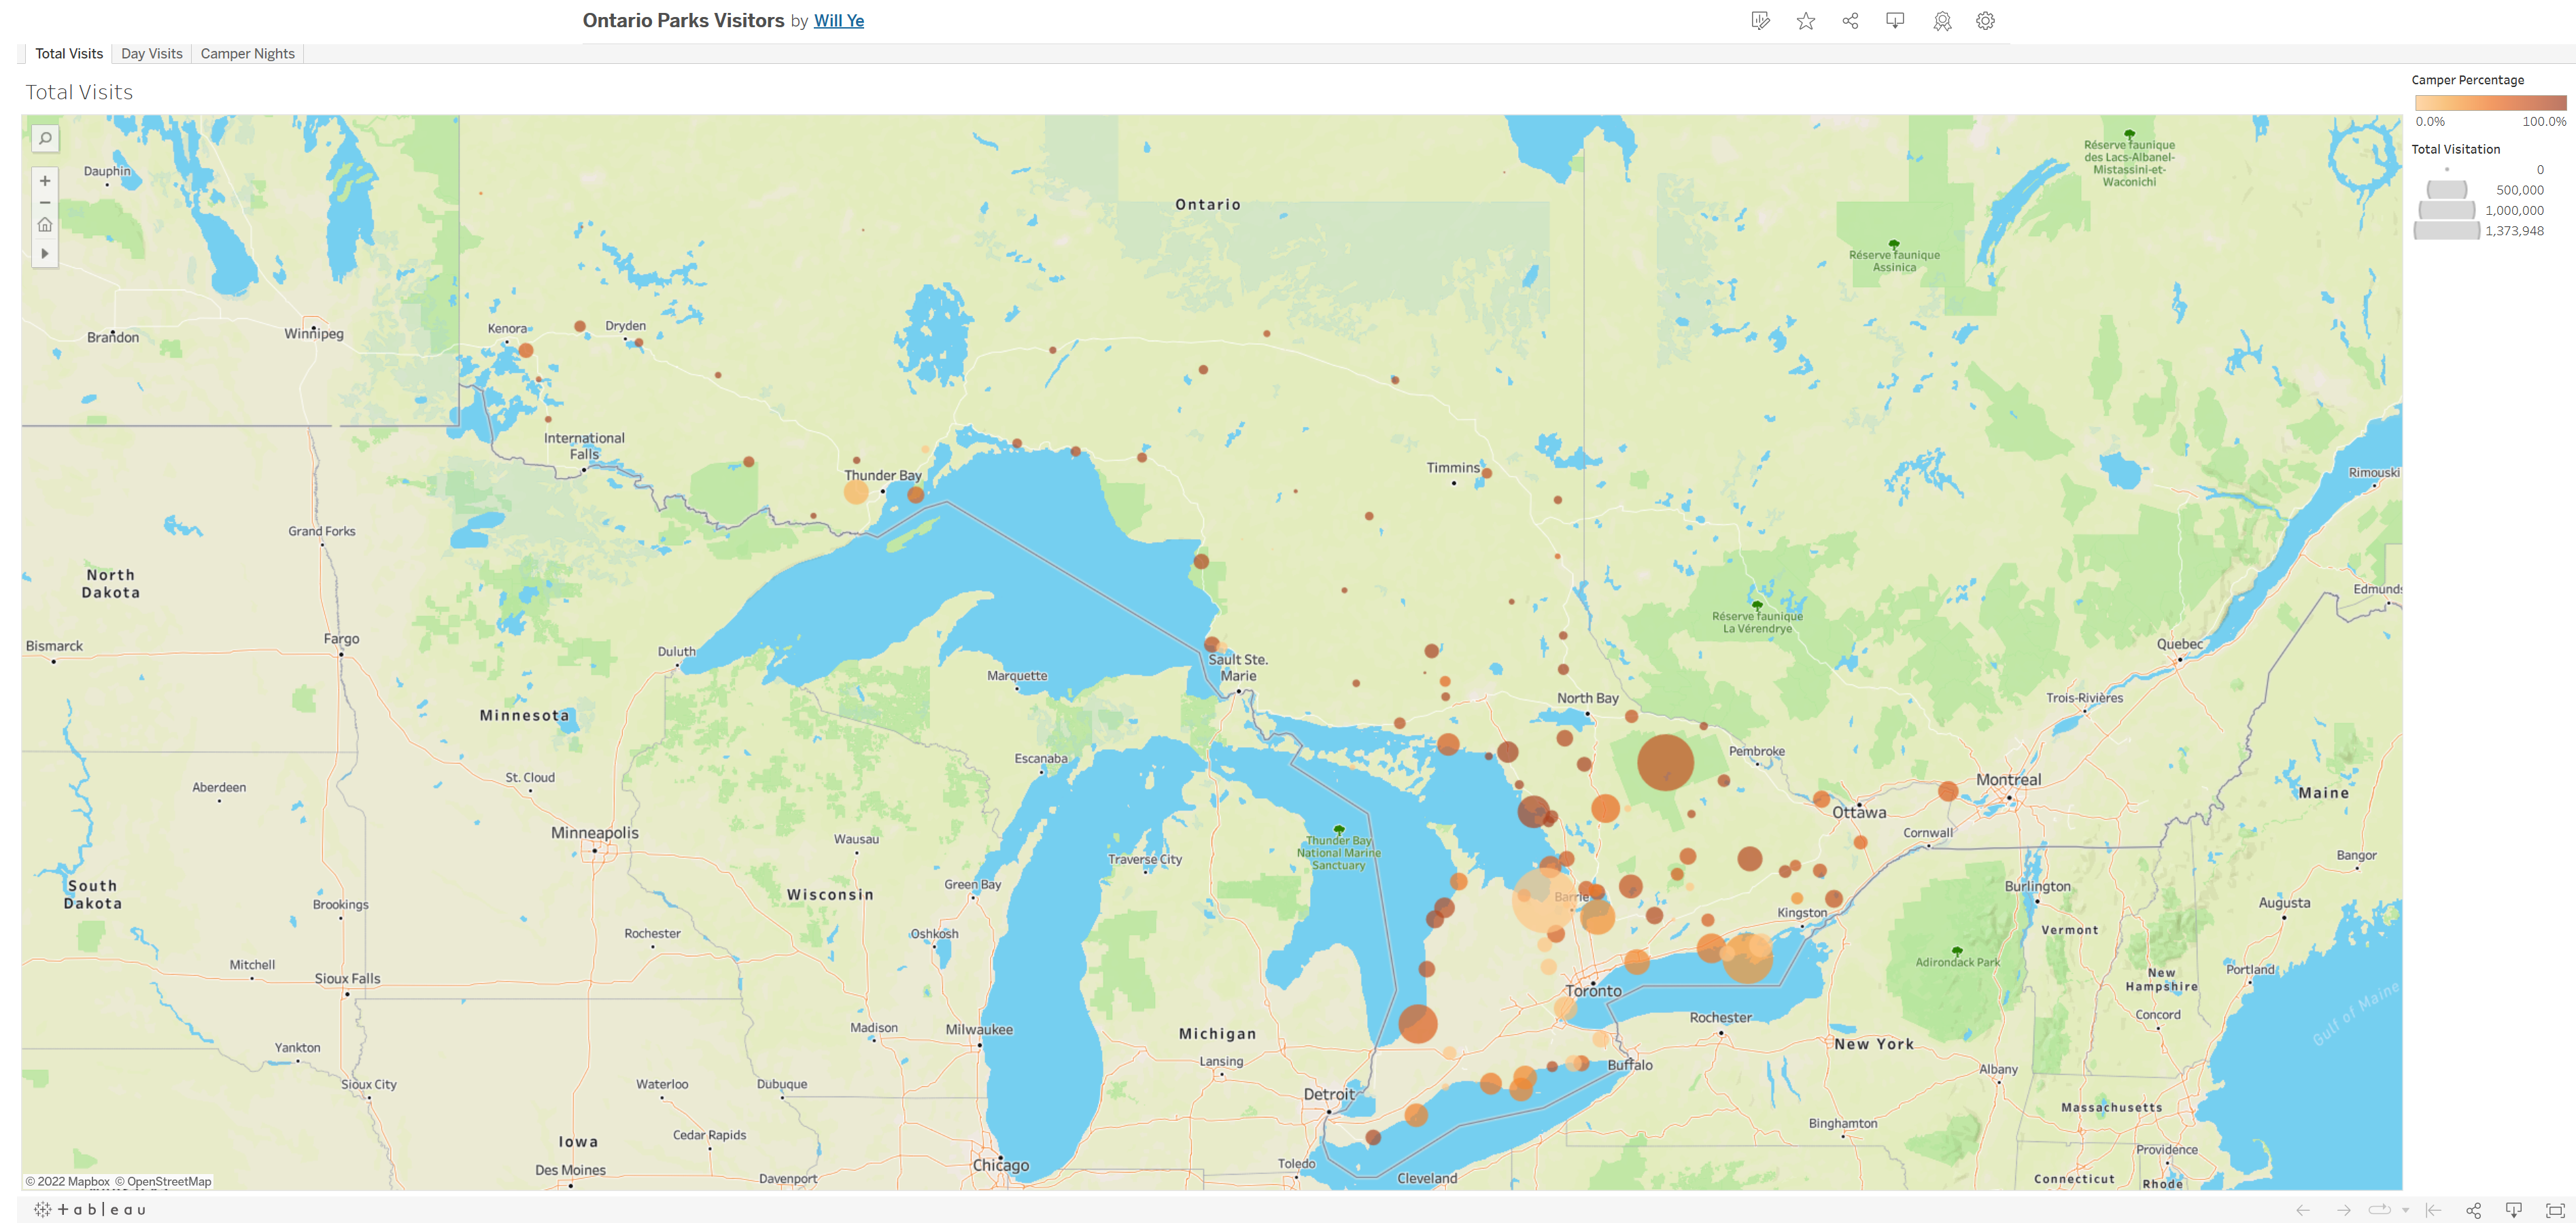

### Feature Engineering/Data Collection

This dataset does not contain any feature that we can use directly to do machine learning, so I will use Beautifulsoup package to do some webscraping from OntarioParks website.